In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from autogluon.tabular import TabularPredictor
import joblib

In [2]:
df = pd.read_csv('openpowerlifting.csv')

# Usuwamy tylko to, co naprawdę nieprzydatne do analizy
to_drop = ['MeetID', 'Division', 'Place', 'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg']
df.drop(columns=[c for c in to_drop if c in df.columns], inplace=True)

# Mapowanie płci na wartości numeryczne
df['Sex'] = df['Sex'].map({'F': 0, 'M': 1})

# Usuwanie duplikatów
df.drop_duplicates(inplace=True)

In [3]:
features_age = ['Sex', 'BodyweightKg', 'BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']

# Przygotowanie zbiorów do trenowania modelu wieku
# dropna(subset=...) zapewnia, że mamy cechy do przewidywania
df_known_age = df[df['Age'].notnull()].dropna(subset=features_age)
df_missing_age = df[df['Age'].isnull()].dropna(subset=features_age)

X_train_age = df_known_age[features_age]
y_train_age = df_known_age['Age']

# Trenowanie regresji dla wieku
reg_age = LinearRegression()
reg_age.fit(X_train_age, y_train_age)

# Przewidywanie i przypisanie
predicted_ages = reg_age.predict(df_missing_age[features_age])
df['ImputedAge'] = df['Age']
df.loc[df_missing_age.index, 'ImputedAge'] = predicted_ages

# Teraz możemy bezpiecznie usunąć oryginalny 'Age' i zapisać model (opcjonalnie)
joblib.dump(reg_age, 'age_imputer_model.pkl')

['age_imputer_model.pkl']

In [4]:
bins = [0, 12, 16, 18, 22, 25, 30, 35, 40, 45, 50, 60, 70, 85, 100]
labels = ['0-11y', '12-15y', '16-17y', '18-21y', '22-24y', '25-29y', '30-34y', '35-39y', '40-44y', '45-49y', '50-59y', '60-69y', '70-84y', '85-100y']

df['AgeGroup'] = pd.cut(df['ImputedAge'], bins=bins, labels=labels, right=False)
df['AgeGroup'] = df['AgeGroup'].cat.add_categories('Unknown').fillna('Unknown')

# Usuwamy wiersze, gdzie wiek nadal jest nieznany (jeśli takie zostały)
df = df[df['AgeGroup'] != 'Unknown']

In [5]:
target = 'Wilks'
features_wilks = ['Sex', 'BodyweightKg', 'BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']

# Przygotowanie danych (usuwamy NaN w kolumnie celowej)
df_clean = df.dropna(subset=[target])
df_clean = df_clean[features_wilks + [target]]

In [6]:
df_sample = df_clean.sample(n=20000, random_state=42)
df_sample = df_sample.reset_index(drop=True)

In [7]:
# Podział
train_data = df_sample.sample(frac=0.8, random_state=42)
test_data = df_sample.drop(train_data.index)

# Trening
predictor = TabularPredictor(label=target).fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20260118_231630"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.0
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 25.2.0: Tue Nov 18 21:09:55 PST 2025; root:xnu-12377.61.12~1/RELEASE_ARM64_T8103
CPU Count:          8
Pytorch Version:    2.9.1
CUDA Version:       CUDA is not available
GPU Count:          WARNING: Exception was raised when calculating GPU count (AssertionError)
Memory Avail:       1.36 GB / 8.00 GB (16.9%)
Disk Space Avail:   17.05 GB / 228.27 GB (7.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme'  : New in v1.5: The state-of-the-art for

[1000]	valid_set's rmse: 3.53783
[2000]	valid_set's rmse: 3.11814
[3000]	valid_set's rmse: 2.96287
[4000]	valid_set's rmse: 2.90942
[5000]	valid_set's rmse: 2.90048
[6000]	valid_set's rmse: 2.8976
[7000]	valid_set's rmse: 2.89155
[8000]	valid_set's rmse: 2.90417


	-2.8902	 = Validation score   (-root_mean_squared_error)
	32.8s	 = Training   runtime
	0.31s	 = Validation runtime
Fitting model: LightGBM ...
	Fitting with cpus=8, gpus=0, mem=0.0/1.4 GB


[1000]	valid_set's rmse: 3.36871
[2000]	valid_set's rmse: 3.29789
[3000]	valid_set's rmse: 3.34297


	-3.2908	 = Validation score   (-root_mean_squared_error)
	11.82s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: RandomForestMSE ...
	Fitting with cpus=8, gpus=0, mem=0.1/1.3 GB
	-4.5913	 = Validation score   (-root_mean_squared_error)
	6.69s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: CatBoost ...
	Fitting with cpus=8, gpus=0
	-1.7341	 = Validation score   (-root_mean_squared_error)
	44.65s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	Fitting with cpus=8, gpus=0, mem=0.1/1.5 GB
	-3.6324	 = Validation score   (-root_mean_squared_error)
	2.06s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	Fitting with cpus=8, gpus=0, mem=0.0/1.3 GB
	-2.3404	 = Validation score   (-root_mean_squared_error)
	9.52s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	Fitting with cpus=8, gpus=0
	-4.6645	 = Validation score   (-root_mean_squared_error)
	7.24s	 =

[1000]	valid_set's rmse: 3.95189


	-3.9456	 = Validation score   (-root_mean_squared_error)
	19.36s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Fitting 1 model on all data | Fitting with cpus=8, gpus=0, mem=0.0/1.6 GB
	Ensemble Weights: {'CatBoost': 0.65, 'NeuralNetFastAI': 0.35}
	-1.4137	 = Validation score   (-root_mean_squared_error)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 140.45s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 48812.8 rows/s (1600 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/Users/dominikpiwowarczyk/Desktop/SUMLProjekt/SUMLfinal/AutogluonModels/ag-20260118_231630")


In [8]:
new_data = pd.DataFrame({
    'Sex': [1],
    'BodyweightKg': [71.94],
    'BestSquatKg': [154.22],
    'BestBenchKg': [115.67],
    'BestDeadliftKg': [183.7],
    'TotalKg': [453.59]
})

predicted_wilks = predictor.predict(new_data)
print(f"Przewidywany Wilks: {predicted_wilks[0]:.2f}")

Przewidywany Wilks: 333.10


In [9]:
!du -sh AutogluonModels/*

819M	AutogluonModels/ag-20260118_231630


In [10]:
# Usuwa wszystkie modele, które nie są potrzebne do działania najlepszego modelu i czysci miejsce 
predictor.delete_models(models_to_keep='best', dry_run=False)
predictor.save_space()

Deleting model LightGBMXT. All files under /Users/dominikpiwowarczyk/Desktop/SUMLProjekt/SUMLfinal/AutogluonModels/ag-20260118_231630/models/LightGBMXT will be removed.
Deleting model LightGBM. All files under /Users/dominikpiwowarczyk/Desktop/SUMLProjekt/SUMLfinal/AutogluonModels/ag-20260118_231630/models/LightGBM will be removed.
Deleting model RandomForestMSE. All files under /Users/dominikpiwowarczyk/Desktop/SUMLProjekt/SUMLfinal/AutogluonModels/ag-20260118_231630/models/RandomForestMSE will be removed.
Deleting model ExtraTreesMSE. All files under /Users/dominikpiwowarczyk/Desktop/SUMLProjekt/SUMLfinal/AutogluonModels/ag-20260118_231630/models/ExtraTreesMSE will be removed.
Deleting model XGBoost. All files under /Users/dominikpiwowarczyk/Desktop/SUMLProjekt/SUMLfinal/AutogluonModels/ag-20260118_231630/models/XGBoost will be removed.
Deleting model NeuralNetTorch. All files under /Users/dominikpiwowarczyk/Desktop/SUMLProjekt/SUMLfinal/AutogluonModels/ag-20260118_231630/models/Neur

In [11]:
!du -sh AutogluonModels/*

 11M	AutogluonModels/ag-20260118_231630


In [12]:
# Wyświetla ranking wszystkich modeli
leaderboard = predictor.leaderboard(test_data, silent=False)
display(leaderboard)

                 model  score_test  score_val              eval_metric  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   -1.623626  -1.413686  root_mean_squared_error        0.197461       0.032778  54.178969                 0.004218                0.000823           0.010099            2       True          3
1             CatBoost   -1.997893  -1.734139  root_mean_squared_error        0.067880       0.011482  44.646502                 0.067880                0.011482          44.646502            1       True          1
2      NeuralNetFastAI   -2.377682  -2.340412  root_mean_squared_error        0.125363       0.020473   9.522368                 0.125363                0.020473           9.522368            1       True          2


,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-1.623626,-1.413686,root_mean_squared_error,0.197461,0.032778,54.178969,0.004218,0.000823,0.010099,2,True,3
1,CatBoost,-1.997893,-1.734139,root_mean_squared_error,0.067880,0.011482,44.646502,0.067880,0.011482,44.646502,1,True,1
2,NeuralNetFastAI,-2.377682,-2.340412,root_mean_squared_error,0.125363,0.020473,9.522368,0.125363,0.020473,9.522368,1,True,2


In [13]:
performance = predictor.evaluate(test_data)
print("Wyniki ewaluacji:")
print(performance)

Wyniki ewaluacji:
{'root_mean_squared_error': np.float64(-1.6236262935350623), 'mean_squared_error': -2.6361623410584043, 'mean_absolute_error': -0.7823931521606448, 'r2': 0.9997320038678255, 'pearsonr': 0.999876615776985, 'median_absolute_error': -0.4904168701171727}


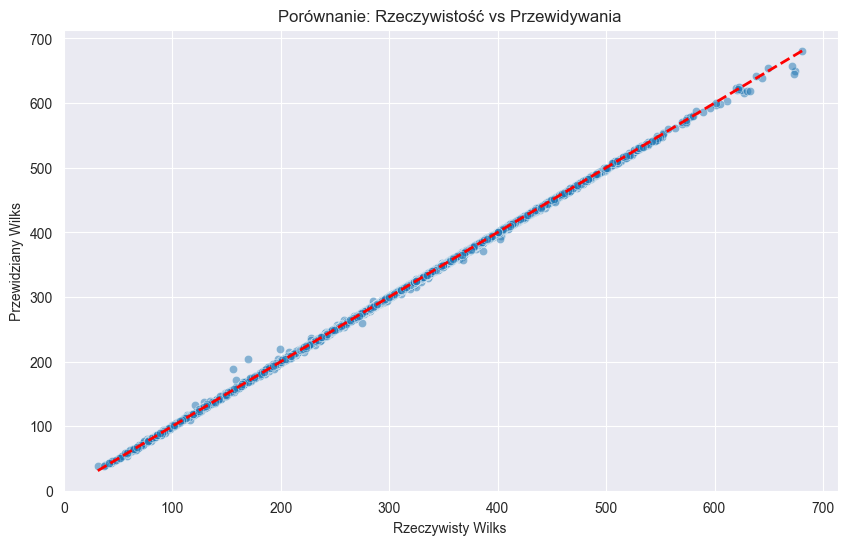

In [14]:
y_test = test_data[target]
y_pred = predictor.predict(test_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Rzeczywisty Wilks')
plt.ylabel('Przewidziany Wilks')
plt.title('Porównanie: Rzeczywistość vs Przewidywania')
plt.show()